##Importing the dataset using Kaggle API key

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.utkface-new-metadata
!mv utkface-new-metadata.json ~/.utkface-new-metadata/
!chmod 600 ~/.utkface-new-metadata/utkface-new-metadata.json
!kaggle datasets download -d jangedoo/utkface-new
!unzip -q utkface-new.zip

Saving utkface-new-metadata.json to utkface-new-metadata.json
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 95% 316M/331M [00:01<00:00, 268MB/s]
100% 331M/331M [00:01<00:00, 243MB/s]


##Importing necessary libraries

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [3]:
# initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

##Extracting the images as pixels and labels as gender

In [4]:
path = "/content/UTKFace"
pixels = []
gender = []
i=0
for img in os.listdir(path):
  i=i+1
  genders = img.split("_")[1]
  img = cv2.imread(str(path)+"/"+str(img))
  img=cv2.resize(img, (img_dims[0],img_dims[1]))
  pixels.append(np.array(img))
  gender.append(np.array(genders))

In [5]:
len(pixels)
len(gender)

23708

In [6]:
# Convert lists to numpy arrays
pixels = np.array(pixels, dtype="float") / 255.0
gender = np.array(gender)

##Splitting for training and validation

In [7]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(pixels, gender, test_size=0.2,random_state=42)

In [8]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# augmenting datset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

###CNN Model

In [9]:
# define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model

# build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

In [10]:
# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
# train the model
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

<ipython-input-11-6fd3f78d1570>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),


Epoch 1/100
296/296 [==============================] - 69s 228ms/step - loss: 0.6299 - accuracy: 0.7196 - val_loss: 0.8586 - val_accuracy: 0.6506
Epoch 2/100
296/296 [==============================] - 66s 222ms/step - loss: 0.4751 - accuracy: 0.7808 - val_loss: 0.6908 - val_accuracy: 0.6506
Epoch 3/100
296/296 [==============================] - 67s 225ms/step - loss: 0.4015 - accuracy: 0.8195 - val_loss: 0.3746 - val_accuracy: 0.8267
Epoch 4/100
296/296 [==============================] - 66s 223ms/step - loss: 0.3620 - accuracy: 0.8358 - val_loss: 0.4104 - val_accuracy: 0.8256
Epoch 5/100
296/296 [==============================] - 66s 221ms/step - loss: 0.3466 - accuracy: 0.8467 - val_loss: 0.3939 - val_accuracy: 0.8340
Epoch 6/100
296/296 [==============================] - 66s 221ms/step - loss: 0.3250 - accuracy: 0.8573 - val_loss: 0.3892 - val_accuracy: 0.8271
Epoch 7/100
296/296 [==============================] - 66s 222ms/step - loss: 0.3225 - accuracy: 0.8588 - val_loss: 0.3056 -

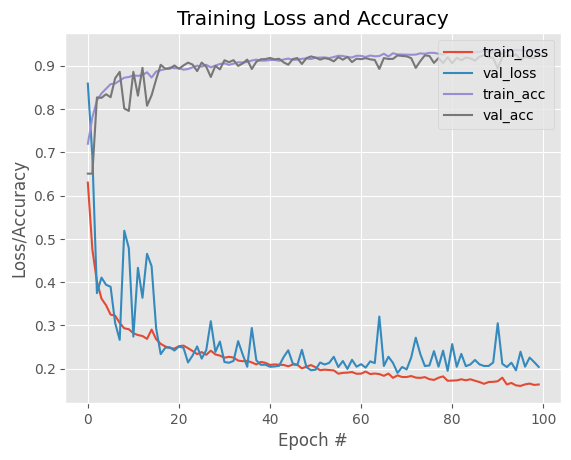

In [12]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

In [21]:
# save the model to disk
model.save('gender_detection.h5')